In [1]:
from PIL import Image as PILImage
from img2table.document import Image
from img2table.ocr import TesseractOCR
from img2table.tables.processing.common import get_contours_cell, is_contained_cell, merge_contours
from img2table.tables.processing.lines import detect_lines
from img2table.tables.objects.cell import Cell
from colordict import ColorDict
import cv2
import numpy as np

In [2]:
import random
colors = ColorDict()

def get_color():
    idx = random.randint(0, len(colors) - 1)
    return list(colors.values())[idx]

### Loading image

In [11]:
img = Image(r"C:\Users\xavca\Pictures\test_aws.jpg")
ocr = TesseractOCR()
ocr_df = ocr.of(img)

img = list(img.images)[0]

### Word image

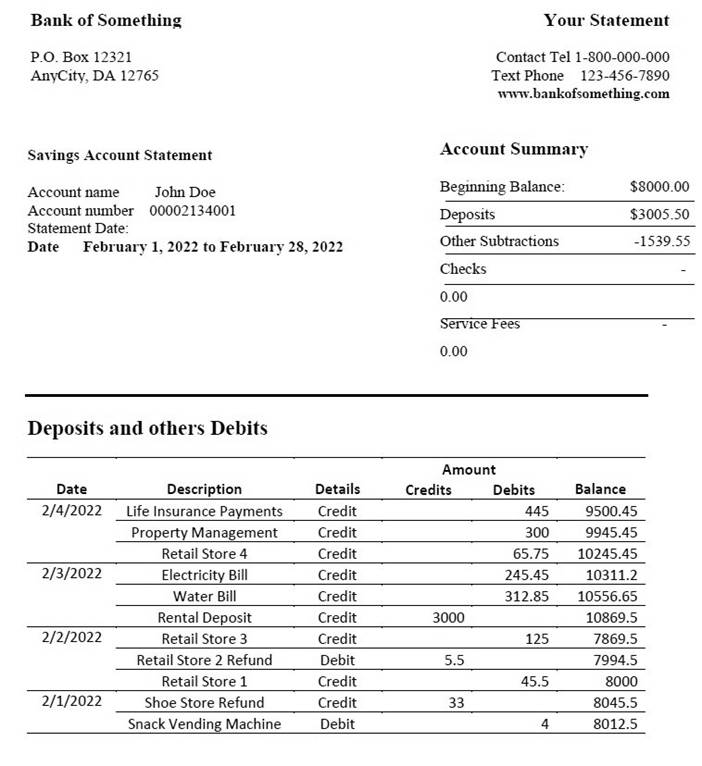

In [12]:
from img2table.tables.processing.tables.implicit_rows import create_word_image

word_image = create_word_image(img=img, ocr_df=ocr_df, min_confidence=20)

PILImage.fromarray(img)

### Text segmentation

In [13]:
from img2table.tables.processing.borderless_tables.segment_image import segment_image_text

img_segments = segment_image_text(img=img, ocr_df=ocr_df)

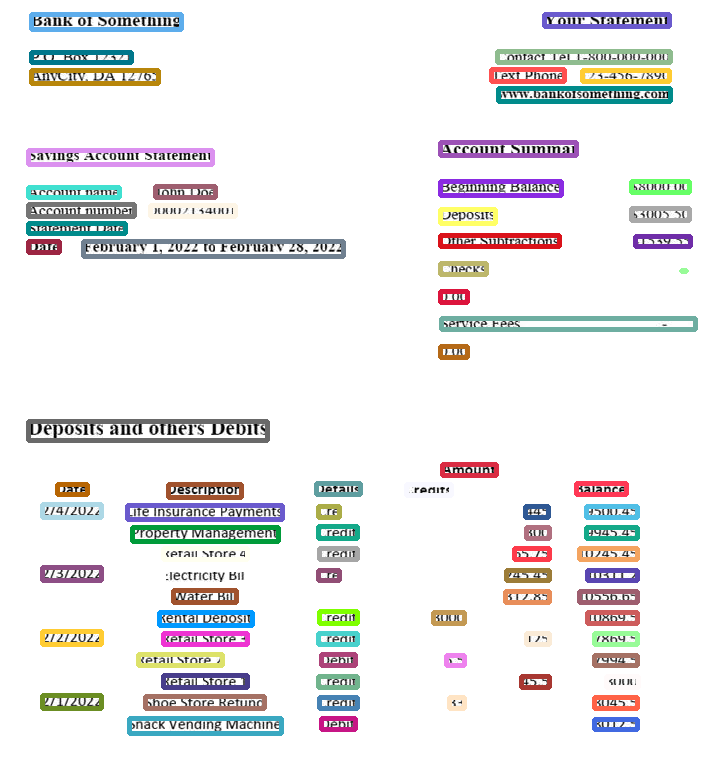

In [14]:
display_img = cv2.cvtColor(word_image.copy(), cv2.COLOR_GRAY2RGB)

for segment in img_segments:
    for cnt in segment:
        cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), get_color(), 3)
PILImage.fromarray(display_img)

### Table detection

In [15]:
from img2table.tables.processing.borderless_tables.alignment import cluster_aligned_text
from img2table.tables.processing.borderless_tables.identify_tables import identify_tables
from img2table.tables.processing.borderless_tables.table_creation import create_table_from_clusters

list_tables = list()
alignment_cls = list()
table_cls = list()
for segment in img_segments:
    # Cluster text contours based on alignment
    alignment_clusters = cluster_aligned_text(segment=segment)
    alignment_cls += alignment_clusters

    # Table detection based on clusters
    table_clusters = identify_tables(clusters=alignment_clusters)
    table_cls += table_clusters

    # Create table objects
    for table_cluster in table_clusters:
        table = create_table_from_clusters(tb_clusters=table_cluster,
                                           segment_cells=[c for c in segment])

        if table:
            list_tables.append(table)

### Alignment

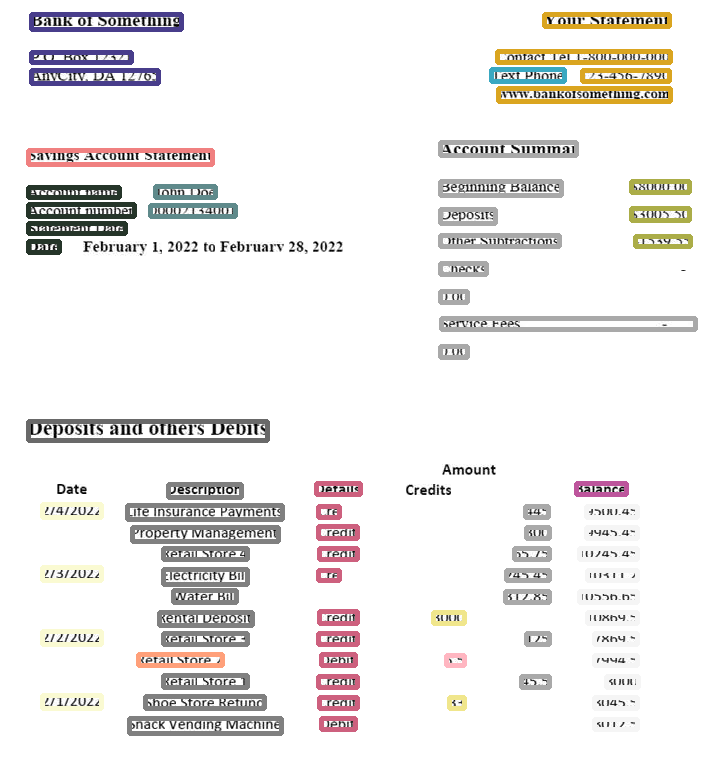

In [16]:
display_img = cv2.cvtColor(word_image.copy(), cv2.COLOR_GRAY2RGB)

for clust in alignment_cls:
    color = get_color()
    for cnt in clust:
        cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), color, 3)

PILImage.fromarray(display_img)

### Clusters

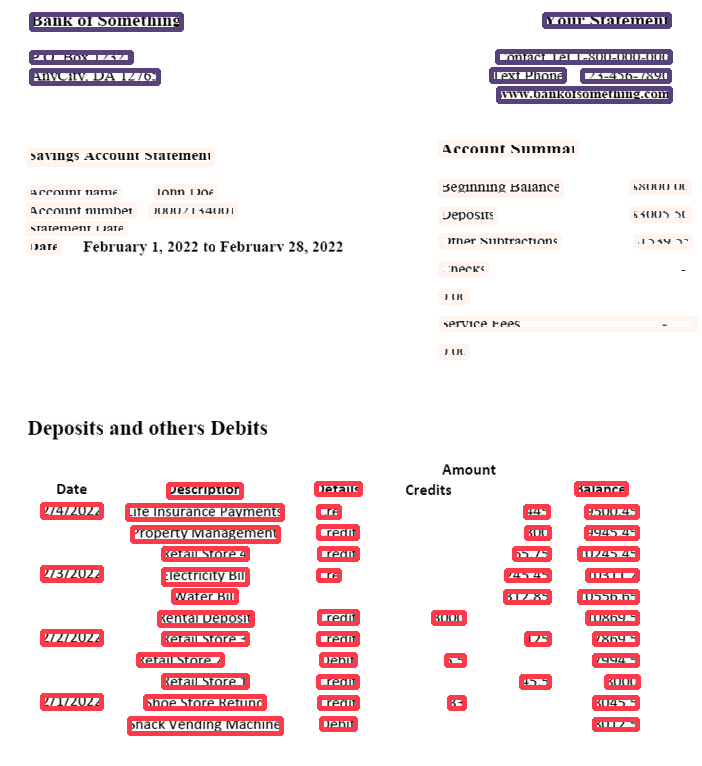

In [17]:
display_img = cv2.cvtColor(word_image.copy(), cv2.COLOR_GRAY2RGB)

for tb in table_cls:
    color = get_color()
    for clust in tb:
        for cnt in clust:
            cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), color, 3)

PILImage.fromarray(display_img)

### Tables

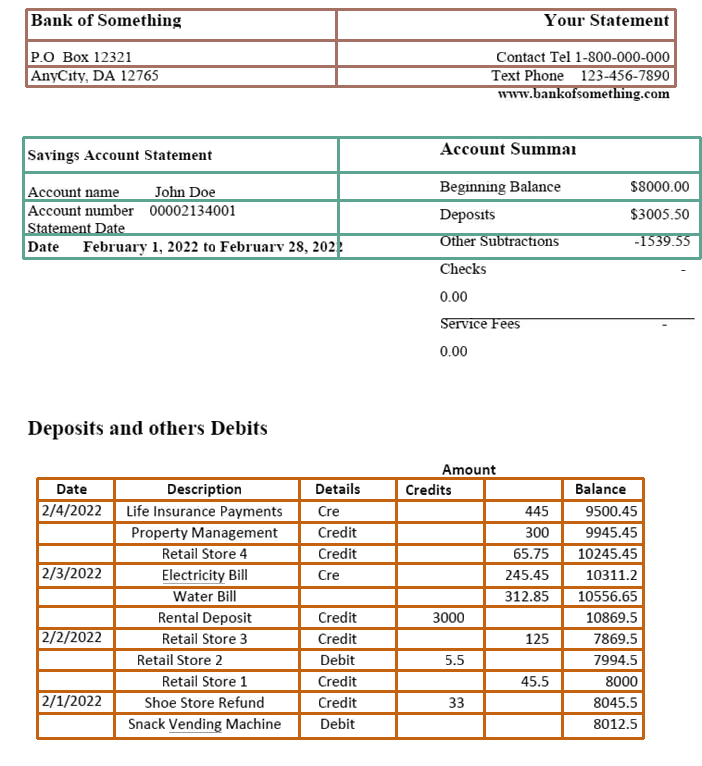

In [18]:
display_img = cv2.cvtColor(word_image.copy(), cv2.COLOR_GRAY2RGB)

for table in list_tables:
    color = get_color()
    for row in table.extracted_table.content.values():
        for cell in row:
            cv2.rectangle(display_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), color, 2)

PILImage.fromarray(display_img)